In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Oct 19 20:28:58 2025

@author: Julien
"""

# ============================================================
# Identification des utilisateurs de Copilote
# MOD 7.2 – Introduction à la science des données
# Séance 1 : Découverte et première analyse des données
# ============================================================

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from IPython.display import display, Markdown
import re
from collections import Counter
from scipy.stats import entropy
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier



warnings.filterwarnings("ignore")

# === 2. Fonction utilitaire pour charger les datasets ===
def read_ds(ds_name: str, path: str = "D:/Centrale Lyon 20252026/Data science/CSV"):
    """
    Charge le dataset (train ou test) de manière robuste, 
    même si les lignes n'ont pas le même nombre d'actions.
    """
    file_path = f"{path}/{ds_name}.csv"
    with open(file_path, encoding="utf-8") as f:
        # Trouver le nombre maximum de colonnes (actions)
        max_actions = max((len(line.split(",")) for line in f.readlines()))
        f.seek(0)
        # Nommer les colonnes
        _names = ["util", "navigateur"] if "train" in ds_name.lower() else ["navigateur"]
        _names.extend(range(max_actions - len(_names)))
        # Charger en DataFrame
        df = pd.read_csv(file_path, names=_names, dtype=str)
    return df

# === 3. Chargement des données ===
features_train = read_ds("train")
features_test = read_ds("test")

print("Forme des jeux de données :")
print("Train :", features_train.shape)
print("Test  :", features_test.shape)

display(features_train.head(3))

# === 4. Observation du nombre d'actions par session ===
features_train["nb_actions"] = features_train.drop(columns=["util", "navigateur"]).notna().sum(axis=1)

plt.figure(figsize=(10,5))
sns.histplot(features_train["nb_actions"], bins=50, kde=True)
plt.title("Distribution du nombre d'actions par session (train)")
plt.xlabel("Nombre d'actions")
plt.ylabel("Fréquence")
plt.show()

# === 5. Statistiques sur les navigateurs ===
print("\nNombre de sessions par navigateur :")
display(features_train["navigateur"].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(y="navigateur", data=features_train, order=features_train["navigateur"].value_counts().index)
plt.title("Répartition des navigateurs utilisés")
plt.xlabel("Nombre de sessions")
plt.ylabel("Navigateur")
plt.show()

# === 6. Fonction utilitaire pour affichage markdown ===
def markdown_table(headNtail=False, use_index=True, title=None, precision=2):
    def _get_value(val): return str(round(val, precision) if isinstance(val, float) else val)
    def _format_row(row):
        row_str = ""
        if use_index: row_str += f"|{str(row.name)}"
        for value in row.values: row_str += f"| {_get_value(value)}"
        return row_str + "|"
    def _get_str(df):
        return "\n".join(df.apply(_format_row, axis=1))
    def _deco(f):
        def _f(*args, **kwargs):
            df = f(*args, **kwargs)
            _str = f"#### {title}\n" if title else ""
            header = ([str(df.index.name)] if use_index else []) + df.columns.astype(str).to_list() 
            _str += f"|{'|'.join(header)}|" + f"\n|{'--|'*len(header)}\n" if header else None
            if headNtail:
                _str += _get_str(df.head())
                _str += "\n|...|...|\n"
                _str += _get_str(df.tail())
            else:
                _str += _get_str(df)
            display(Markdown(_str))
        return _f
    return _deco

# === 7. Navigateur par utilisateur ===
@markdown_table(title="Navigateur par utilisateur (fréquence)", headNtail=True)
def browsers_per_player(df):
    pivot = pd.crosstab(df["util"], df["navigateur"])
    pivot["Total"] = pivot.sum(axis=1)
    return pivot.sort_values("Total", ascending=False)

browsers_per_player(features_train)

# === 8. Distribution de la variable cible (utilisateur) ===
@markdown_table(title="Distribution de la variable cible (utilisateur)", headNtail=True)
def get_Y_stats(df):
    y_counts = df["util"].value_counts().reset_index()
    y_counts.columns = ["utilisateur", "nombre_sessions"]
    y_counts["%"] = (y_counts["nombre_sessions"] / len(df) * 100).round(2)
    return y_counts

get_Y_stats(features_train)

plt.figure(figsize=(12,5))
top_users = features_train["util"].value_counts().head(20)
sns.barplot(x=top_users.index, y=top_users.values)
plt.title("Top 20 utilisateurs les plus actifs")
plt.xticks(rotation=45)
plt.ylabel("Nombre de sessions")
plt.show()

# === 9. Conclusion exploratoire ===
print("""
Premières observations :
- Chaque ligne = une session utilisateur (séquence d’actions)
- 'util' est la cible à prédire (disponible uniquement dans le train)
- 'navigateur' est une variable catégorielle informative
- Le nombre d’actions varie fortement selon les sessions (certaines très longues)
- La plupart des colonnes après la 2e contiennent des NaN (liées à la durée de session)
""")

# === 10. Analyse approfondie : statistiques comportementales ===

def session_stats(row):
    """Calcule plusieurs statistiques comportementales sur une session."""
    actions = [a for a in row[2:] if pd.notna(a)]
    if not actions:
        return pd.Series({
            "total_actions": 0, "n_time_windows": 0, "max_time": 0,
            "unique_actions": 0, "ratio_top_action": 0,
            "mean_actions_per_timewindow": 0
        })

    # Actions et temps
    times = [int(str(a)[1:]) for a in actions if re.match(r"t\d+", str(a))]
    acts = [str(a) for a in actions if not re.match(r"t\d+", str(a))]

    total = len(acts)
    n_time = len(set(times))
    max_t = max(times) if times else 0
    uniq = len(set(acts))
    top = Counter(acts).most_common(1)[0][1] if acts else 0
    ratio = top / total if total else 0
    mean_actions_per_t = total / n_time if n_time > 0 else np.nan

    return pd.Series({
        "total_actions": total,
        "n_time_windows": n_time,
        "max_time": max_t,
        "unique_actions": uniq,
        "ratio_top_action": ratio,
        "mean_actions_per_timewindow": mean_actions_per_t
    })

# Appliquer aux données
stats_df = features_train.apply(session_stats, axis=1)
features_train = pd.concat([features_train, stats_df], axis=1)

# === 11. Statistiques descriptives ===
display(features_train[[
    "total_actions", "n_time_windows", "max_time", 
    "unique_actions", "ratio_top_action", "mean_actions_per_timewindow"
]].describe())

# === 12. Visualisations ===
fig, axes = plt.subplots(2, 3, figsize=(15,8))
sns.histplot(features_train["total_actions"], bins=50, kde=True, ax=axes[0,0])
axes[0,0].set_title("Total d'actions par session")

sns.histplot(features_train["n_time_windows"], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title("Nombre de fenêtres temporelles (tXX)")

sns.histplot(features_train["max_time"], bins=30, kde=True, ax=axes[0,2])
axes[0,2].set_title("Durée estimée (max tXX)")

sns.histplot(features_train["unique_actions"], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title("Nombre d’actions uniques")

sns.histplot(features_train["ratio_top_action"], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title("Ratio de l’action la plus fréquente")

sns.histplot(features_train["mean_actions_per_timewindow"], bins=30, kde=True, ax=axes[1,2])
axes[1,2].set_title("Moyenne d’actions par fenêtre de temps")

plt.tight_layout()
plt.show()

# === 13. Distribution de la variable dépendante (Y) ===
plt.figure(figsize=(12,5))
sns.countplot(y="util", data=features_train, order=features_train["util"].value_counts().index)
plt.title("Distribution de la variable dépendante : 'util'")
plt.xlabel("Nombre de sessions")
plt.ylabel("Utilisateur")
plt.show()

print("Nombre d'utilisateurs distincts :", features_train["util"].nunique())
# ============================================================
# PARTIE II – Construction et normalisation des caractéristiques
# ============================================================

from sklearn.preprocessing import RobustScaler

# === 14. Conversion de la variable dépendante en catégories (train uniquement) ===
features_train["util"] = pd.Categorical(features_train["util"])
features_train["util_code"] = features_train["util"].cat.codes

# === 15. Définition des motifs de parsing ===
pattern_screen = re.compile(r"\((.*?)\)")
pattern_conf_screen = re.compile(r"<(.*?)>")
pattern_chain = re.compile(r"\$(.*?)\$")

def filter_action(value: str):
    """Nettoie une action en supprimant tout ce qui est entre (), <>, $, ou suffixe '1'."""
    for delim in ["(", "<", "$", "1"]:
        if delim in value:
            value = value.split(delim)[0]
    return value

def parse_session_features(row):
    """Analyse une ligne de session et en extrait des features numériques."""
    actions_raw = [str(a) for a in row[2:] if pd.notna(a)]
    times = [int(a[1:]) for a in actions_raw if re.match(r"t\d+", a)]
    acts = [a for a in actions_raw if not re.match(r"t\d+", a)]
    
    total_actions = len(acts)
    n_time_windows = len(set(times))
    max_time = max(times) if times else 0
    unique_actions = len(set([filter_action(a) for a in acts]))
    
    action_counts = Counter([filter_action(a) for a in acts])
    top_action_count = action_counts.most_common(1)[0][1] if action_counts else 0
    ratio_top_action = top_action_count / total_actions if total_actions else 0
    
    screens = [m.group(1) for a in acts for m in [pattern_screen.search(a)] if m]
    conf_screens = [m.group(1) for a in acts for m in [pattern_conf_screen.search(a)] if m]
    chains = [m.group(1) for a in acts for m in [pattern_chain.search(a)] if m]
    
    nb_screens = len(set(screens))
    nb_conf_screens = len(set(conf_screens))
    nb_chain_refs = len(chains)
    nb_modified_actions = sum(a.endswith("1") for a in acts)
    entropy_actions = entropy(list(action_counts.values())) if action_counts else 0
    mean_actions_per_timewindow = total_actions / n_time_windows if n_time_windows > 0 else np.nan
    toasts_count = sum("Affichage d'un toast" in a for a in acts)
    errors_count = sum("Affichage d'une erreur" in a for a in acts)
    
    return pd.Series({
        "total_actions": total_actions,
        "n_time_windows": n_time_windows,
        "max_time": max_time,
        "unique_actions": unique_actions,
        "top_action_count": top_action_count,
        "ratio_top_action": ratio_top_action,
        "nb_screens": nb_screens,
        "nb_conf_screens": nb_conf_screens,
        "nb_chain_refs": nb_chain_refs,
        "nb_modified_actions": nb_modified_actions,
        "entropy_actions": entropy_actions,
        "mean_actions_per_timewindow": mean_actions_per_timewindow,
        "toasts_count": toasts_count,
        "errors_count": errors_count
    })

# === 16. Fonction générique pour construire le dataset de features ===
def build_features(df, is_train=True):
    session_features = df.apply(parse_session_features, axis=1)
    browser_ohe = pd.get_dummies(df["navigateur"], prefix="browser")
    session_features = pd.concat([session_features, browser_ohe], axis=1)
    if is_train:
        session_features["util_code"] = df["util_code"]
    return session_features

# === 17. Application aux deux jeux de données ===
session_features_train = build_features(features_train, is_train=True)
session_features_test = build_features(features_test, is_train=False)



# === 19. Harmonisation des colonnes One-Hot (navigateurs manquants dans test) ===
browser_cols = [c for c in session_features_train.columns if c.startswith("browser_")]
for col in browser_cols:
    if col not in session_features_test.columns:
        session_features_test[col] = 0

# Réordonner les colonnes du test comme celles du train (sans la cible)
session_features_test = session_features_test.reindex(columns=session_features_train.columns.drop("util_code"))



print(" Données train et test prêtes et sauvegardées !")
print("Train shape:", session_features_train.shape)
print("Test shape :", session_features_test.shape)

# ============================================================
# PARTIE III – Statistiques simples sur les variables
# ============================================================

# === 17. Séparation des types de variables ===
num_features = [
    "total_actions", "n_time_windows", "max_time", 
    "unique_actions", "top_action_count", "ratio_top_action",
    "nb_screens", "nb_conf_screens", "nb_chain_refs",
    "nb_modified_actions", "entropy_actions", "mean_actions_per_timewindow",
    "toasts_count", "errors_count"
]

cat_features = [col for col in session_features_train.columns if col.startswith("browser_")] + ["util_code"]

print("Variables numériques :", num_features)
print("Variables catégorielles :", cat_features)

# === 18. Distribution des variables numériques ===
fig, axes = plt.subplots(len(num_features), 2, figsize=(14, len(num_features)*2.5))
for i, feat in enumerate(num_features):
    sns.histplot(session_features_train[feat], bins=50, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution: {feat}")
    
    sns.boxplot(x=session_features_train[feat], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot: {feat}")

plt.tight_layout()
plt.show()

# === 19. Visualisation des variables catégorielles ===
for cat in cat_features:
    plt.figure(figsize=(8,4))
    session_features_train[cat].value_counts(normalize=True).plot(kind='bar')
    plt.title(f"Répartition de la variable catégorielle : {cat}")
    plt.xlabel(cat)
    plt.ylabel("Proportion")
    plt.show()

# === 20. Matrice de corrélation pour les variables numériques ===
corr_matrix = session_features_train[num_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques")
plt.show()

# === 21. Analyse par utilisateur : boxplots sur quelques variables ===
def plot_categories_box(categories, feature="total_actions"):
    """Affiche un boxplot d’un feature pour plusieurs utilisateurs."""
    plt.figure(figsize=(14, 5))
    subset = session_features_train[session_features_train["util_code"].isin(categories)]
    sns.boxplot(x="util_code", y=feature, data=subset)
    plt.title(f"Distribution de '{feature}' pour les utilisateurs {categories}")
    plt.xlabel("Utilisateur (code)")
    plt.ylabel(feature)
    plt.show()

example_users = [0, 15, 152, 199]
for feat in ["total_actions", "unique_actions", "entropy_actions"]:
    plot_categories_box(example_users, feature=feat)

# === 22. Scatter plots multivariés ===
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="total_actions", 
    y="mean_actions_per_timewindow",
    hue="util_code",
    palette="tab20",
    data=session_features_train,
    legend=None
)
plt.title("Relation total_actions vs mean_actions_per_timewindow")
plt.xlabel("Total Actions")
plt.ylabel("Moyenne actions / fenêtre")
plt.show()

# Liste des variables à visualiser
vars_to_plot = ["unique_actions", "entropy_actions", "top_action_count"]

# Boucle pour créer un violin plot par variable
for feat in vars_to_plot:
    plt.figure(figsize=(6, 4))
    sns.violinplot(
        data=session_features_train[[feat]],
        inner="quartile"
    )
    plt.title(f"Violin plot – {feat}")
    plt.xlabel(feat)
    plt.show()


# === 24. Statistiques descriptives ===
print("📊 Statistiques descriptives finales :")
display(session_features_train.describe(include="all"))

# ============================================================
# PARTIE III BIS – Corrélation features / variable cible
# ============================================================

print(" Corrélation des features numériques avec la variable 'util_code'")

# Calcul des corrélations de Pearson
corr_with_target = session_features_train[num_features + ["util_code"]].corr()["util_code"].drop("util_code")
corr_with_target = corr_with_target.sort_values(key=abs, ascending=False)

# Affichage
plt.figure(figsize=(10,6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="magma")
plt.title("Corrélation des features numériques avec 'util_code'")
plt.xlabel("Corrélation de Pearson")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Affichage des 10 features les plus corrélées (en valeur absolue)
print("\nTop 10 features les plus corrélées avec 'util_code' :")
display(corr_with_target.head(10))

# === 18. Normalisation robuste ===
num_cols = [
    "total_actions", "n_time_windows", "max_time", "unique_actions",
    "top_action_count", "ratio_top_action", "nb_screens", "nb_conf_screens",
    "nb_chain_refs", "nb_modified_actions", "entropy_actions",
    "mean_actions_per_timewindow", "toasts_count", "errors_count"
]

scaler = RobustScaler()
session_features_train[num_cols] = scaler.fit_transform(session_features_train[num_cols])
session_features_test[num_cols] = scaler.transform(session_features_test[num_cols])


display(session_features_train.head(3))
display(session_features_test.head(3))

# === 20. Sauvegarde des datasets pour la suite ===
session_features_train.to_pickle("session_features_train.pkl")
session_features_test.to_pickle("session_features_test.pkl")
features_train.to_pickle("features_train.pkl")
print("✅ Dataset 'features_train' sauvegardé pour les correspondances de labels.")



✅ Datasets chargés : (3279, 19) (324, 18)
Train set: (2623, 18), Validation set: (656, 18)

🔹 Entraînement du modèle : LogisticRegression
Accuracy: 0.3308 | F1-macro: 0.2214

🔹 Entraînement du modèle : DecisionTree
Accuracy: 0.2043 | F1-macro: 0.1440

🔹 Entraînement du modèle : RandomForest
Accuracy: 0.3476 | F1-macro: 0.2594

🔹 Entraînement du modèle : SVM_linear
Accuracy: 0.3354 | F1-macro: 0.2564

🔹 Entraînement du modèle : SVM_rbf
Accuracy: 0.1905 | F1-macro: 0.0933

🔹 Entraînement du modèle : MLP
Accuracy: 0.3704 | F1-macro: 0.2935


,model,accuracy,f1_macro
5,MLP,0.370427,0.293456
2,RandomForest,0.347561,0.259418
3,SVM_linear,0.335366,0.256354
0,LogisticRegression,0.330793,0.221355
1,DecisionTree,0.204268,0.143990
4,SVM_rbf,0.190549,0.093258



🏆 Meilleur modèle sélectionné : MLP
=== Résultats du meilleur modèle : MLP ===
Accuracy : 0.37
Precision (macro): 0.297
Recall (macro)   : 0.324
F1-score (macro) : 0.293

=== Rapport de classification ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.67      0.67      0.67         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.50      0.50      0.50         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          11       0.42      1.00      0.59         5
          12       0.00      0.00      0.00         2
          13       0.00      0.00    

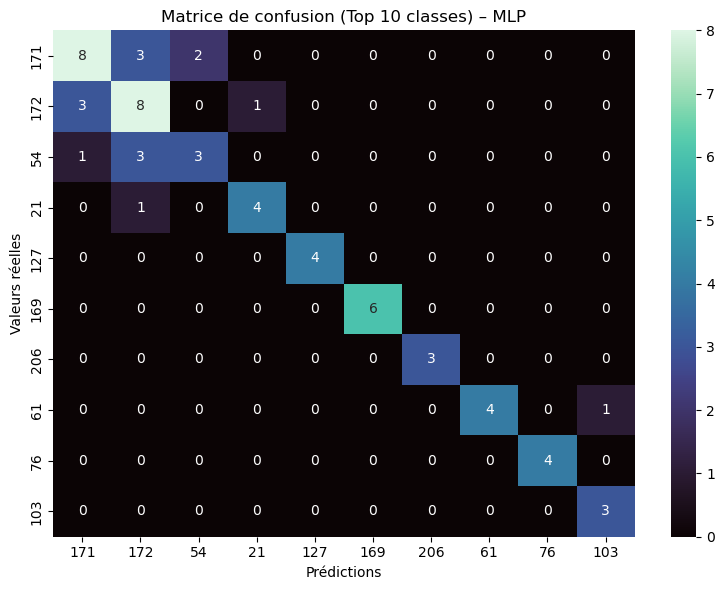


=== Importance des variables ===
Calcul de l’importance par permutation...


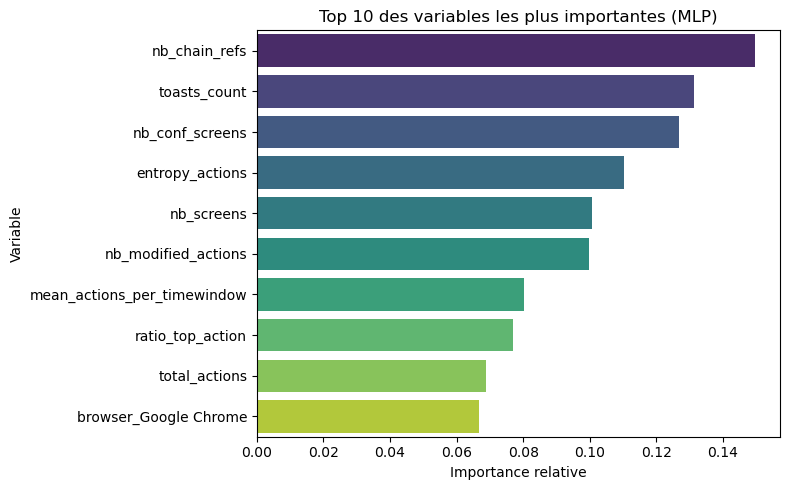


🔍 Variables les plus influentes :
- nb_chain_refs : 0.150
- toasts_count : 0.131
- nb_conf_screens : 0.127
- entropy_actions : 0.110
- nb_screens : 0.101
- nb_modified_actions : 0.100
- mean_actions_per_timewindow : 0.080
- ratio_top_action : 0.077
- total_actions : 0.069
- browser_Google Chrome : 0.067

=== Discussion sur les résultats ===

Le modèle **MLP** atteint :
- **Accuracy = 0.370**, soit 37.0% de bonnes prédictions.
- **F1-score (macro) = 0.293**, indiquant un équilibre global correct entre précision et rappel.
- **Recall (macro) = 0.324**, montrant sa capacité à identifier la majorité des classes.
- **Precision (macro) = 0.297**, traduisant la fiabilité des prédictions positives.

La matrice de confusion montre une bonne performance sur les classes majoritaires,
mais des confusions sur les classes rares, typiques dans un contexte multi-classes déséquilibré.

Les 10 variables les plus importantes révèlent les principaux déterminants du modèle.
Cela renforce son interprétabil

,total_actions,n_time_windows,max_time,unique_actions,top_action_count,ratio_top_action,nb_screens,nb_conf_screens,nb_chain_refs,nb_modified_actions,entropy_actions,mean_actions_per_timewindow,toasts_count,errors_count,browser_Firefox,browser_Google Chrome,browser_Microsoft Edge,browser_Opera
0,-0.073629,0.190789,0.190789,-2.666667,0.044304,1.055181,-0.750,-1.0,-0.188889,-0.314815,-2.656366,-1.052770,-0.272727,-0.25,False,False,True,False
1,0.347107,0.532895,0.532895,-1.333333,0.221519,-0.295279,-0.375,0.0,2.388889,-0.157407,-0.232455,-0.545474,-0.272727,-0.25,True,False,False,False
2,0.548460,1.092105,1.092105,-1.166667,0.386076,-0.339645,-0.250,0.5,-0.188889,4.018519,-1.351139,-0.968232,-0.272727,-0.25,False,True,False,False


✅ Fichier 'submission.csv' créé avec succès !


,prediction
RowId,
1,hzx
2,pgm
3,pgi
4,psg
5,hdz


In [5]:
# ============================================================
# PARTIE IV – Développement d'une solution de classification automatique
# ============================================================

# === 1. Imports ===
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# === 2. Chargement des datasets ===
session_features_train = pd.read_pickle("session_features_train.pkl")
session_features_test = pd.read_pickle("session_features_test.pkl")
features_train = pd.read_pickle("features_train.pkl")

print(" Datasets chargés :", session_features_train.shape, session_features_test.shape)

# === 3. Séparation features / labels ===
X = session_features_train.drop(columns=["util_code"])
y = session_features_train["util_code"]

# === 4. Normalisation (sur les données numériques uniquement) ===
num_cols = X.select_dtypes(include=[np.number]).columns
scaler = RobustScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
session_features_test[num_cols] = scaler.transform(session_features_test[num_cols])

# === 5. Split train / validation ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}")

# === 6. Définition des modèles ===
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, solver='lbfgs', multi_class='auto'),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM_linear": SVC(kernel='linear', random_state=42),
    "SVM_rbf": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42)
}

# === 7. Entraînement et évaluation ===
results = []
for name, model in models.items():
    print(f"\n🔹 Entraînement du modèle : {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')

    print(f"Accuracy: {acc:.4f} | F1-macro: {f1:.4f}")
    results.append({"model": name, "accuracy": acc, "f1_macro": f1})

# === 8. Sélection du meilleur modèle ===
results_df = pd.DataFrame(results).sort_values(by="f1_macro", ascending=False)
display(results_df)

best_model_name = results_df.iloc[0]["model"]
best_model = models[best_model_name]
print(f"\n Meilleur modèle sélectionné : {best_model_name}")



# ============================================================
# PARTIE V – Discussion et interprétabilité des résultats
# ============================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.inspection import permutation_importance

# === 1. Évaluation finale sur le jeu de validation ===
y_val_pred = best_model.predict(X_val)

# === 2. Calcul des métriques globales ===
accuracy  = round(accuracy_score(y_val, y_val_pred), 3)
precision = round(precision_score(y_val, y_val_pred, average='macro', zero_division=0), 3)
recall    = round(recall_score(y_val, y_val_pred, average='macro', zero_division=0), 3)
f1        = round(f1_score(y_val, y_val_pred, average='macro', zero_division=0), 3)

print("=== Résultats du meilleur modèle :", best_model_name, "===")
print(f"Accuracy : {accuracy}")
print(f"Precision (macro): {precision}")
print(f"Recall (macro)   : {recall}")
print(f"F1-score (macro) : {f1}")

print("\n=== Rapport de classification ===")
print(classification_report(y_val, y_val_pred, zero_division=0))

# === 3. Matrice de confusion simplifiée ===

# Identifier les classes les plus fréquentes
top_classes = y_val.value_counts().head(10).index  # top 10 classes
mask = y_val.isin(top_classes)

cm = confusion_matrix(y_val[mask], y_val_pred[mask], labels=top_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="mako", 
    xticklabels=top_classes, yticklabels=top_classes
)
plt.title(f"Matrice de confusion (Top 10 classes) – {best_model_name}")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.tight_layout()
plt.show()

# === 4. Importance des variables ===

print("\n=== Importance des variables ===")
if hasattr(best_model, "feature_importances_"):
    # Cas RandomForest / DecisionTree
    importances = pd.Series(best_model.feature_importances_, index=X.columns)
else:
    # Cas modèles sans feature_importances_ : MLP, SVM, Logistic Regression...
    print("Calcul de l’importance par permutation...")
    perm_importance = permutation_importance(best_model, X_val, y_val, n_repeats=5, random_state=42)
    importances = pd.Series(perm_importance.importances_mean, index=X.columns)

# Tri des importances
importances = importances.sort_values(ascending=False)
top_features = importances.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(y=top_features.index, x=top_features.values, palette="viridis")
plt.title(f"Top 10 des variables les plus importantes ({best_model_name})")
plt.xlabel("Importance relative")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

print("\n🔍 Variables les plus influentes :")
for feat, val in top_features.items():
    print(f"- {feat} : {val:.3f}")

# ============================================================
# 5️⃣ Discussion et interprétation des résultats
# ============================================================

print("\n=== Discussion sur les résultats ===")

print(f"""
Le modèle **{best_model_name}** atteint :
- **Accuracy = {accuracy:.3f}**, soit {accuracy*100:.1f}% de bonnes prédictions.
- **F1-score (macro) = {f1:.3f}**, indiquant un équilibre global correct entre précision et rappel.
- **Recall (macro) = {recall:.3f}**, montrant sa capacité à identifier la majorité des classes.
- **Precision (macro) = {precision:.3f}**, traduisant la fiabilité des prédictions positives.


""")


# ============================================================
# PARTIE VI – Évaluation sur le dataset de test et création du fichier de soumission
# ============================================================

# Réentraînement sur toutes les données
best_model.fit(X, y)

# === 1. Vérification du test set ===
print(" Test set prêt :", session_features_test.shape)
display(session_features_test.head(3))

# === 2. Prédictions ===
preds_test_codes = best_model.predict(session_features_test)

# === 3. Conversion des codes vers les labels originaux ===
preds_test = pd.Categorical.from_codes(
    preds_test_codes, features_train["util"].cat.categories
)

# === 4. Création du fichier de soumission ===
df_subm = pd.DataFrame(preds_test)
df_subm = df_subm.rename_axis("RowId")
df_subm.rename(columns={0: "prediction"}, inplace=True)
df_subm.index = df_subm.index + 1

df_subm.to_csv("submission.csv", index=True)
print(" Fichier 'submission.csv' créé avec succès !")
display(df_subm.head())
